In [1]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import os
from kernel import ARDKernel
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS
JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

### 核心思想

在训练过程中，有时会遇到Cholesky分解报错的情况，这是由于矩阵非正定（not positive definite）引起的。为了解决这个问题，我们采用特征分解（Eigen decomposition）的方式，通过移除特征值较小的部分来重新构造一个正定矩阵。

### 特征分解

设核矩阵 $K$ 为：

$$ K = Q \Lambda Q^T $$

其中：
- $Q$ 是特征向量矩阵。
- $\Lambda$ 是特征值对角矩阵。

### 处理小特征值

为了确保矩阵正定，我们将特征值中小于 $1 \times 10^{-4}$ 的部分移除。具体步骤如下：

1. **特征分解**：对矩阵 $K$ 进行特征分解，得到特征值和特征向量。
2. **移除小特征值**：将特征值中小于 $1 \times 10^{-4}$ 的部分移除，同时移除对应的特征向量。
3. **重构矩阵**：使用剩余的特征值和特征向量重构矩阵。

### 计算逆矩阵和行列式

重构后的矩阵 $K_{\text{new}}$ 可表示为：

$$ K_{\text{new}} = Q_{\text{new}} \Lambda_{\text{new}} Q_{\text{new}}^T $$

其中 $\Lambda_{\text{new}}$ 和 $Q_{\text{new}}$ 分别是移除小特征值和对应特征向量后的特征值和特征向量矩阵。

#### 计算逆矩阵

$$ K_{\text{new}}^{-1} = Q_{\text{new}} \Lambda_{\text{new}}^{-1} Q_{\text{new}}^T $$

#### 计算行列式的对数

$$ \log \det K_{\text{new}} = \sum_{i} \log \lambda_{i,\text{new}} $$

其中 $\lambda_{i,\text{new}}$ 是重构后的特征值。

### 负对数似然

负对数似然（NLL）的计算公式为：

$$ \text{NLL} = \frac{1}{2} \left( \mathbf{y}^T K_{\text{new}}^{-1} \mathbf{y} + \log \det K_{\text{new}} + n \log 2\pi \right) $$


In [2]:
# implement eigendecomposition
def compute_inverse_and_log_det_positive_eigen(matrix):
    """
    Perform eigen decomposition, remove non-positive eigenvalues,
    and compute the inverse matrix and the log determinant of the matrix.
    
    Parameters:
    matrix (torch.Tensor): Input matrix for decomposition.
    
    Returns:
    torch.Tensor: Inverse of the matrix with non-positive eigenvalues removed.
    torch.Tensor: Log determinant of the matrix with non-positive eigenvalues removed.
    """
    eigenvalues, eigenvectors = torch.linalg.eig(matrix)
    eigenvalues = eigenvalues.real
    eigenvectors = eigenvectors.real
    #print(eigenvalues)
    positive_indices = eigenvalues > 1e-4
    removed_count = torch.sum(~positive_indices).item()
    if removed_count > 0:
        print(f"Removed {removed_count} small or non-positive eigenvalue(s).")
    eigenvalues = eigenvalues[positive_indices]
    eigenvectors = eigenvectors[:, positive_indices]
    inv_eigenvalues = torch.diag(1.0 / eigenvalues)
    inverse_matrix = eigenvectors @ inv_eigenvalues @ eigenvectors.T
    log_det_K = torch.sum(torch.log(eigenvalues))
    return inverse_matrix, log_det_K

In [3]:
#用上述模块搭建蕴含这种计算方法的cigp
class cigp(nn.Module):
    def __init__(self, X, Y, normal_y_mode=0):
        # normal_y_mode = 0: normalize Y by combing all dimension.
        # normal_y_mode = 1: normalize Y by each dimension.
        super(cigp, self).__init__()
        self.kernel = ARDKernel(1)
        #normalize X independently for each dimension
        self.Xmean = X.mean(0)
        self.Xstd = X.std(0)
        self.X = (X - self.Xmean.expand_as(X)) / (self.Xstd.expand_as(X) + EPS)

        if normal_y_mode == 0:
            # normalize y all together
            self.Ymean = Y.mean()
            self.Ystd = Y.std()
            self.Y = (Y - self.Ymean.expand_as(Y)) / (self.Ystd.expand_as(Y) + EPS)
        elif normal_y_mode == 1:
        # option 2: normalize y by each dimension
            self.Ymean = Y.mean(0)
            self.Ystd = Y.std(0)
            self.Y = (Y - self.Ymean.expand_as(Y)) / (self.Ystd.expand_as(Y) + EPS)

        # GP hyperparameters
        self.log_beta = nn.Parameter(torch.ones(1) * 0)   # a large noise by default. Smaller value makes larger noise variance.




    def forward(self, Xte):
        n_test = Xte.size(0)
        Xte = ( Xte - self.Xmean.expand_as(Xte) ) / self.Xstd.expand_as(Xte)

        Sigma = self.kernel(self.X, self.X) + self.log_beta.exp().pow(-1) * torch.eye(self.X.size(0)) \
            + JITTER * torch.eye(self.X.size(0))

        kx = self.kernel(self.X, Xte)
        L = torch.cholesky(Sigma)
        LinvKx,_ = torch.triangular_solve(kx, L, upper = False)

        # option 1
        mean = kx.t() @ torch.cholesky_solve(self.Y, L)  # torch.linalg.cholesky()
        
        var_diag = self.kernel(Xte, Xte).diag().view(-1, 1) \
            - (LinvKx**2).sum(dim = 0).view(-1, 1)

        # add the noise uncertainty
        var_diag = var_diag + self.log_beta.exp().pow(-1)

        # de-normalized
        mean = mean * self.Ystd.expand_as(mean) + self.Ymean.expand_as(mean)
        var_diag = var_diag.expand_as(mean) * self.Ystd**2

        return mean, var_diag


    def negative_log_likelihood(self):
        y_num, y_dimension = self.Y.shape
        Sigma = self.kernel(self.X, self.X) + self.log_beta.exp().pow(-1) * torch.eye(
            self.X.size(0)) + JITTER * torch.eye(self.X.size(0))

        L = torch.linalg.cholesky(Sigma)
        #option 1 (use this if torch supports)
        Gamma,_ = torch.triangular_solve(self.Y, L, upper = False)
        #option 2
        # gamma = L.inverse() @ Y       # we can use this as an alternative because L is a lower triangular matrix.

        nll =  0.5 * (Gamma ** 2).sum() +  L.diag().log().sum() * y_dimension  \
            + 0.5 * y_num * torch.log(2 * torch.tensor(PI)) * y_dimension
        return nll
        
    
    def negative_log_likelihood_eigen(self):
        y_num, y_dimension = self.Y.shape
        K_xx=self.kernel(self.X,self.X)+JITTER * torch.eye(self.X.size(0))
        K_inv,log_det_K=compute_inverse_and_log_det_positive_eigen(K_xx)
        nll = 0.5 * (self.Y.T @ K_inv @ self.Y + log_det_K + y_num * torch.log(2 * torch.tensor(torch.pi)))
        return nll
        
    def train_adam(self, niteration=10, lr=0.1, loss_type='nll'):
        # adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for i in range(niteration):
            optimizer.zero_grad()
            if loss_type == 'nll':
                loss = self.negative_log_likelihood()
            elif loss_type == 'eigen_nll':
                loss = self.negative_log_likelihood_eigen()
            else:
                raise ValueError("Invalid loss_type. Use 'nll' or 'eigen_nll'.")
            
            loss.backward()
            optimizer.step()
            print(f'iter {i}, nll: {loss.item():.5f}')

xtr.size: torch.Size([100, 1]) ytr.size: torch.Size([100, 1])
xte.size: torch.Size([100, 1]) yte.size: torch.Size([100, 1])


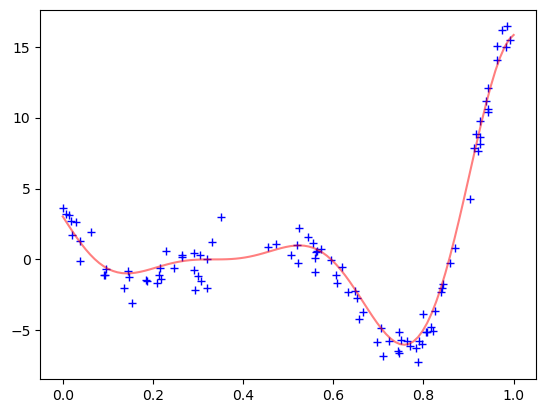

In [7]:
torch.manual_seed(4)
xtr = torch.rand(100, 1)
ytr = ((6*xtr - 2)**2) * torch.sin(12*xtr - 4) + torch.randn(100, 1) * 1

#test_set
xte = torch.linspace(0, 1, 100).view(-1,1)
yte = ((6*xte - 2)**2) * torch.sin(12*xte - 4)

#plot the data
print("xtr.size:", xtr.size(), "ytr.size:", ytr.size())
print("xte.size:", xte.size(), "yte.size:", yte.size())
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.plot(xte.numpy(), yte.numpy(), 'r-', alpha = 0.5)
plt.show()

In [9]:
model=cigp(xtr,ytr)
model.train_adam(100,0.01,loss_type='eigen_nll')

Removed 92 small or non-positive eigenvalue(s).
iter 0, nll: 1844.54773
Removed 92 small or non-positive eigenvalue(s).
iter 1, nll: 1629.25781
Removed 92 small or non-positive eigenvalue(s).
iter 2, nll: 1439.91406
Removed 92 small or non-positive eigenvalue(s).
iter 3, nll: 1281.54602
Removed 92 small or non-positive eigenvalue(s).
iter 4, nll: 1135.74963
Removed 92 small or non-positive eigenvalue(s).
iter 5, nll: 1012.83142
Removed 92 small or non-positive eigenvalue(s).
iter 6, nll: 903.71167
Removed 92 small or non-positive eigenvalue(s).
iter 7, nll: 809.54712
Removed 91 small or non-positive eigenvalue(s).
iter 8, nll: 1704.73657
Removed 91 small or non-positive eigenvalue(s).
iter 9, nll: 1496.68750
Removed 91 small or non-positive eigenvalue(s).
iter 10, nll: 1300.59985
Removed 91 small or non-positive eigenvalue(s).
iter 11, nll: 1131.61401
Removed 91 small or non-positive eigenvalue(s).
iter 12, nll: 978.85156
Removed 91 small or non-positive eigenvalue(s).
iter 13, nll: 85

C:\Users\28772\AppData\Local\Temp\ipykernel_73116\1224320300.py:39: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2198.)
  LinvKx,_ = torch.triangular_solve(kx, L, upper = False)


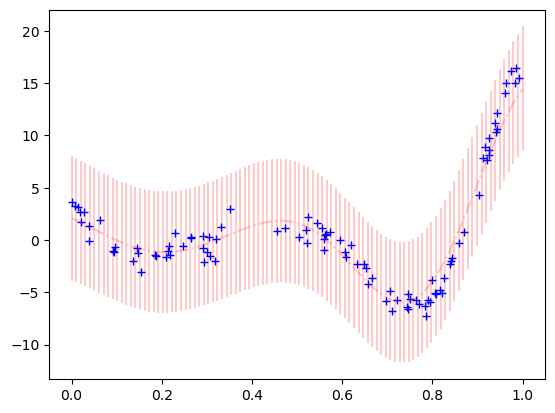

In [10]:
with torch.no_grad():
    ypred, yvar = model.forward(xte)
    
plt.errorbar(xte.numpy().reshape(100), ypred.detach().numpy().reshape(100),
             yerr=yvar.sqrt().squeeze().detach().numpy(), fmt='r-.', alpha=0.2)
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.show()

iter 0, nll: 120.89912
iter 1, nll: 120.24985
iter 2, nll: 119.58597
iter 3, nll: 118.90713
iter 4, nll: 118.21309
iter 5, nll: 117.50372
iter 6, nll: 116.77896
iter 7, nll: 116.03896
iter 8, nll: 115.28394
iter 9, nll: 114.51433
iter 10, nll: 113.73070
iter 11, nll: 112.93382
iter 12, nll: 112.12464
iter 13, nll: 111.30428
iter 14, nll: 110.47402
iter 15, nll: 109.63534
iter 16, nll: 108.78983
iter 17, nll: 107.93922
iter 18, nll: 107.08533
iter 19, nll: 106.23006
iter 20, nll: 105.37533
iter 21, nll: 104.52302
iter 22, nll: 103.67502
iter 23, nll: 102.83309
iter 24, nll: 101.99887
iter 25, nll: 101.17387
iter 26, nll: 100.35944
iter 27, nll: 99.55666
iter 28, nll: 98.76645
iter 29, nll: 97.98950
iter 30, nll: 97.22627
iter 31, nll: 96.47701
iter 32, nll: 95.74178
iter 33, nll: 95.02047
iter 34, nll: 94.31278
iter 35, nll: 93.61836
iter 36, nll: 92.93674
iter 37, nll: 92.26735
iter 38, nll: 91.60966
iter 39, nll: 90.96311
iter 40, nll: 90.32716
iter 41, nll: 89.70134
iter 42, nll: 89.

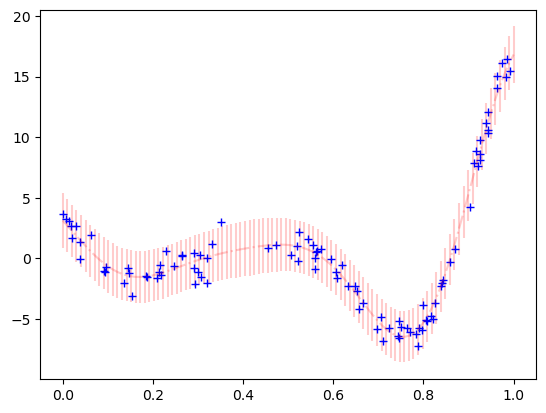

In [11]:
model2=cigp(xtr,ytr)
model2.train_adam(200,0.01,loss_type='nll')
with torch.no_grad():
    ypred, yvar = model2.forward(xte)
    
plt.errorbar(xte.numpy().reshape(100), ypred.detach().numpy().reshape(100),
             yerr=yvar.sqrt().squeeze().detach().numpy(), fmt='r-.', alpha=0.2)
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.show()

In [12]:
def calculate_mse(model, x_test, y_test):
    model.eval()  # 切换模型到评估模式
    with torch.no_grad():  # 关闭梯度计算
        y_pred, _ = model.forward(x_test)  # 获取模型预测输出
        mse_loss = nn.MSELoss()(y_pred, y_test)  # 计算 MSE
    return mse_loss.item()

In [13]:
print(calculate_mse(model,xte,yte),
calculate_mse(model2,xte,yte))

0.859667181968689 0.2178863137960434
